# Explore Results EMR Kerr

## Import utils

In [21]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

data_path = project_path * "data/input/case_1/";
output_directory = project_path * "data/output/case_1/kerr/";

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
using DelimitedFiles;
import BSON: @save, @load
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


## Data paths

In [32]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_data = true

# paths
test_name = "test_1_cos/"

output_dir = output_directory* "models/" * test_name
predictions_dir = output_dir * "predictions/"
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/";

list_directories = (predictions_dir)
create_directories(list_directories)

## Load Model

In [24]:

# Define the experimental parameters
global datasize = 250
global mass_ratio = 0.0
global dt = 100.0


## Define neural network model
_, _, chain, _ = nn_model_case1(test_name)

# load saved models
@load solutions_dir*"model_chiphi.bson" chain

# restructure chains
NN_params, re = Flux.destructure(chain)
NN(u, NN_params) = re(NN_params)(u);

## Dataset

Note that here you create a new dataset for train/test purpose. It might seem a bad practice but the idea was to enable to select only what is needed for train/test. This could be easily changed and datasets for train/test process written and read in this notebook

In [25]:

datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters
println("Train dataset creation")

χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
p=Float64(80.0); 
M=Float64(1.0); 
e = Float64(0.4)
tspan_train = (0, 6.0f4)
a=0.5

train_info = [get_problem_information_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_train, datasize, dt);]

# TEST waveform parameters
println("Test dataset creation")

χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
p=Float64(80.0); 
M=Float64(1.0); 
e = Float64(0.4)
tspan_test = (tspan_train[2]*48, tspan_train[2]*50)
a=0.5
factor = 5
extended_tspan = (tspan_test[1], factor*tspan_test[2])

test_info = [get_problem_information_EMR_kerr(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt)];

# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);


Train dataset creation
Test dataset creation
Processing datasets
Creating test dataset 
Creating train dataset 


## Get predictions

In [59]:
# save predictions
predictions = Dict("train" => [], "test" => [])

for (set, set_data) in processed_data

    for wave in set_data

        println("Obtaining predictions for: ", set, " : ", wave["index"])

        solution_nn = Array(
            solve(wave["nn_problem"], RK4(), u0 = wave["u0"], 
            p = NN_params, saveat = wave["tsteps"], 
            dt = wave["dt_data"], adaptive=false
        ))

        predictions_wave_i = Dict()

        predictions_wave_i["tsteps"] = wave["tsteps"]
        predictions_wave_i["true_waveform"] = wave["true_waveform"]
        predictions_wave_i["pred_waveform"], _ = compute_waveform(wave["dt_data"], solution_nn, wave["q"], wave["M"], wave["model_params"])
        predictions_wave_i["pred_solution"] = solution_nn
        predictions_wave_i["true_solution"] = solution_nn
        predictions_wave_i["pred_orbit"] = soln2orbit(solution_nn, wave["M"], wave["model_params"])
        predictions_wave_i["true_orbit"] = soln2orbit(wave["true_solution"], wave["M"], wave["model_params"])    

        push!(predictions[set], predictions_wave_i)

    end

end


Obtaining predictions for: test : 1
Obtaining predictions for: train : 1


## Save predictions

In [58]:
# NOTE: this can be easily convert into a function and iterate over systems to save info

set = "train" # "test"
wave_index = 1 #

waveform_results_to_save = predictions[set][wave_index]

orbits = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_orbit_x" => waveform_results_to_save["pred_orbit"][1, :],
    "pred_orbit_y" => waveform_results_to_save["pred_orbit"][2, :],
    "true_orbit_x" => waveform_results_to_save["true_orbit"][1, :],
    "true_orbit_y" => waveform_results_to_save["true_orbit"][2, :]
)

equation_of_motion = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_solution_chi" => waveform_results_to_save["pred_solution"][1, :],
    "pred_solution_phi" => waveform_results_to_save["pred_solution"][2, :],
    "true_solution_chi" => waveform_results_to_save["true_solution"][1, :],
    "true_solution_phi" => waveform_results_to_save["true_solution"][2, :]
)

waveforms = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_waveform" => waveform_results_to_save["pred_waveform"],
    "true_waveform" => waveform_results_to_save["true_waveform"]
)


CSV.write(predictions_dir*"waveforms.csv", waveforms)
CSV.write(predictions_dir*"equation_of_motion.csv", equation_of_motion)
CSV.write(predictions_dir*"orbits.csv", orbits);

"../../../../../data/output/case_1/kerr/models/test_1_cos/predictions/orbits.csv"

## Plots

In [118]:
plot_list = [];

for (set, set_data) in predictions

    for wave in set_data

        title = uppercasefirst(set) * " predictions"

        # waveforms
        x1 = plot(
            wave["tsteps"], wave["true_waveform"], 
            markershape=:none, alpha = 0.5, legend=false, 
            # title= title,
            label="wform data (Re)",
            xlabel="Time",
            ylabel="Waveform",
            framestyle=:box,
            linewidth = line_width,
            left_margin = 20Plots.mm,
            bottom_margin = 5Plots.mm,
            size=(1200,350),
    
            color=:black,
            seriestype=:scatter,
            ms=5,
        )
        plot!(
            x1, 
            wave["tsteps"], wave["pred_waveform"], 
            markershape=:none, linewidth = 2, alpha = 0.5, 
            label="wform NN (Re)",
                
            framestyle=:box,

            legendfontsize=legend_font_size,
            # titlefontsize=title_font_size,
            # guidefontsize=title_font_size,
            # tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
        )

        # orbits
        orbits = wave["pred_orbit"]
        N = size(orbits, 2)
        x2 = plot(
            wave["true_orbit"][1,:][1:N],
            wave["true_orbit"][2,:][1:N],
            alpha = 0.5, aspect_ratio=:equal,
            label="data",
            xlabel="x",
            ylabel="y",
    
            bottom_margin = 5Plots.mm,
    
            legendfontsize=legend_font_size,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            left_margin = 20Plots.mm,
            framestyle=:box,
            color=:black,
            legend=:outertop,  
        )
        plot!(x2, orbits[1,1:end-1], orbits[2,1:end-1],
            alpha = 0.5, 
            aspect_ratio=:equal,
            label="NN",
            framestyle=:box,
            legendfontsize=legend_font_size,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            # linestyle=:dash
        )

        plt = plot(x1, x2, layout=grid(1,2), size=(2000, 900))
        push!(plot_list, plt)
    
    end

end

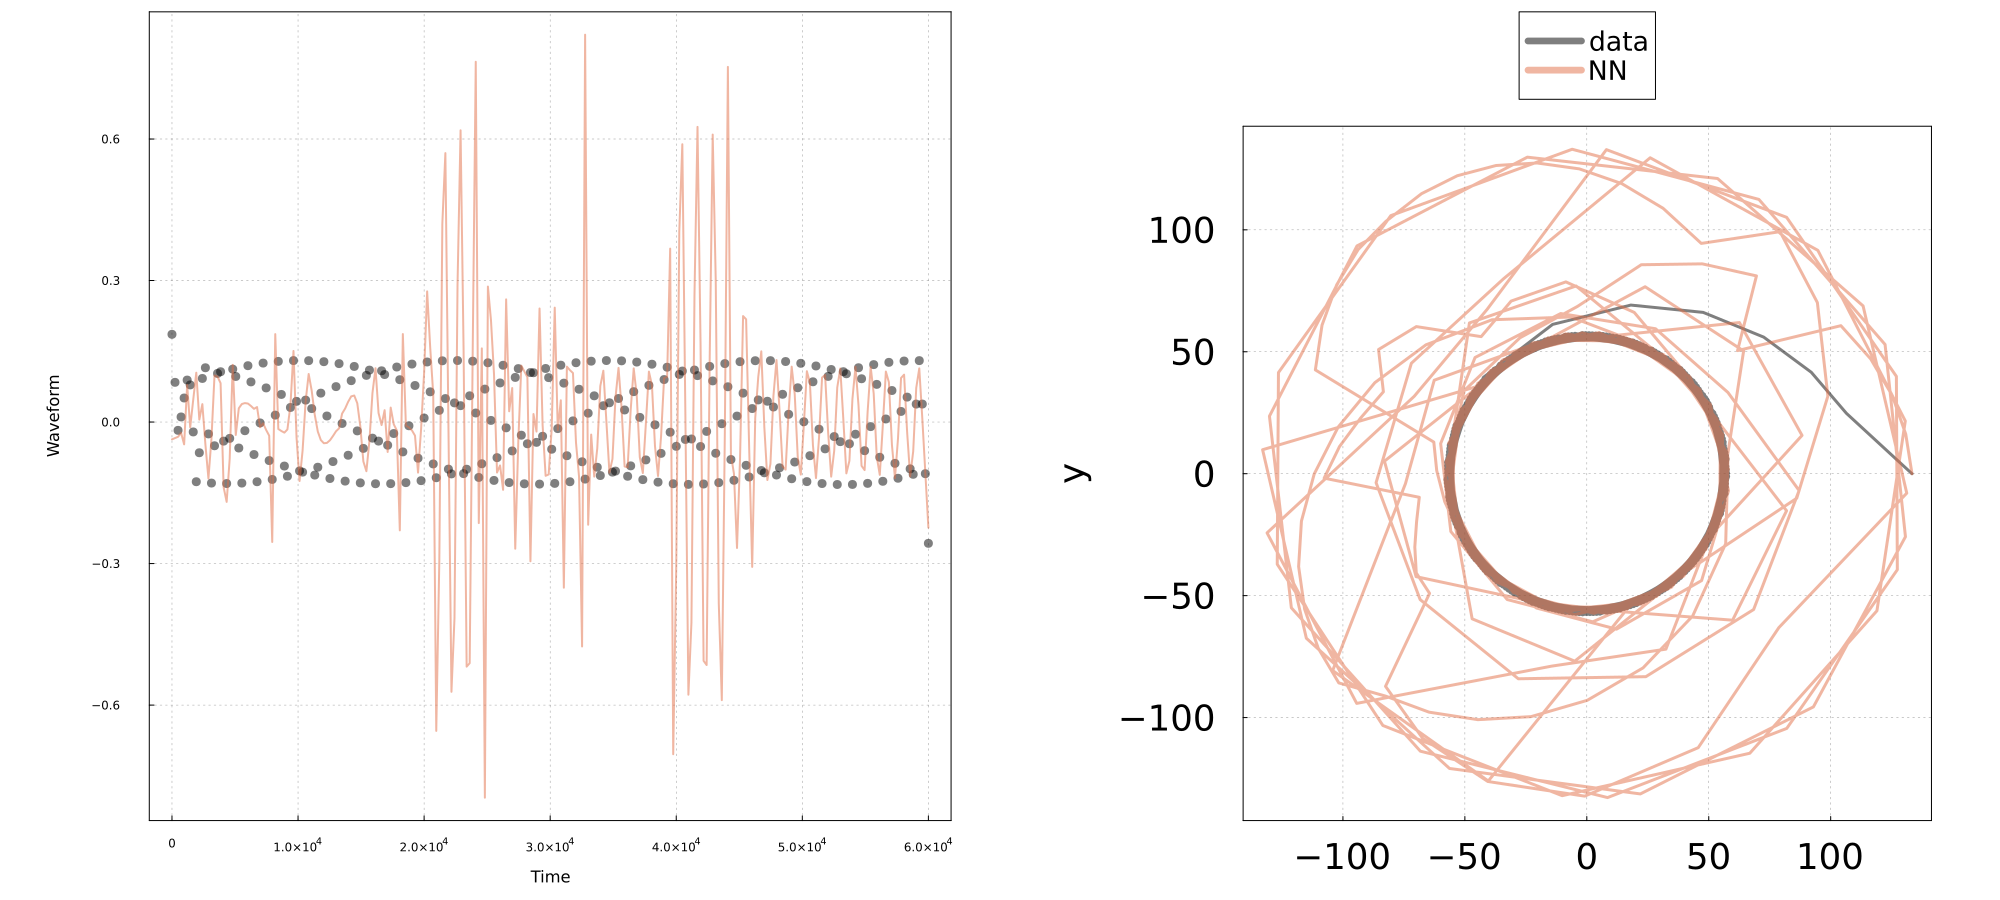

In [119]:
display(plot_list[end])

In [78]:
savefig(plt, predictions_dir*"orbits_plot.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/data/output/case_1/kerr/models/test_1_cos/predictions/orbits_plot.png"